## 4. Generate "Similar" Datasets for Transfer Learning Testing

We'll create:

1. A "long" time series (3 years) - the source domain
2. A "short" time series (3 months) - the target domain, similar to the long one

The idea is to fit on the long series and tune on the short series.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.utils import metrics

# Set random seed for reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


In [3]:
def generate_similar_time_series(
    n_days,
    start_date,
    series_name,
    trend_slope=0.1,
    trend_intercept=100,
    yearly_amplitude=20,
    weekly_amplitude=5,
    noise_level=5,
    random_seed=None,
):
    """
    Generate a synthetic time series with trend and seasonality.

    Parameters
    ----------
    n_days : int
        Number of days to generate.
    start_date : str
        Start date in 'YYYY-MM-DD' format.
    series_name : str
        Name of the time series.
    trend_slope : float
        Slope of the linear trend.
    trend_intercept : float
        Intercept of the linear trend.
    yearly_amplitude : float
        Amplitude of yearly seasonality.
    weekly_amplitude : float
        Amplitude of weekly seasonality.
    noise_level : float
        Standard deviation of Gaussian noise.
    random_seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns 'ds', 'y', 'series'.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    dates = pd.date_range(start=start_date, periods=n_days, freq="D")
    t = np.arange(n_days)

    # Trend component
    trend = trend_slope * t + trend_intercept

    # Yearly seasonality
    yearly = yearly_amplitude * np.sin(2 * np.pi * t / 365.25)

    # Weekly seasonality
    weekly = weekly_amplitude * np.sin(2 * np.pi * t / 7)

    # Noise
    noise = np.random.randn(n_days) * noise_level

    # Combine (additive)
    y = trend + yearly + weekly + noise

    return pd.DataFrame({"ds": dates, "y": y, "series": series_name})

In [4]:
# Generate long time series (3 years)
long_series = generate_similar_time_series(
    n_days=3 * 365,
    start_date="2020-01-01",
    series_name="long_series",
    trend_slope=0.05,
    trend_intercept=100,
    yearly_amplitude=25,
    weekly_amplitude=8,
    noise_level=3,
    random_seed=42,
)

print(f"Long series: {len(long_series)} days")
print(f"Date range: {long_series['ds'].min()} to {long_series['ds'].max()}")

Long series: 1095 days
Date range: 2020-01-01 00:00:00 to 2022-12-30 00:00:00


In [5]:
# Generate short time series (3 months) - similar but slightly different parameters
short_series = generate_similar_time_series(
    n_days=90,
    start_date="2023-01-01",
    series_name="short_series",
    trend_slope=0.06,  # Slightly different slope
    trend_intercept=150,  # Different baseline
    yearly_amplitude=25,  # Same yearly amplitude
    weekly_amplitude=8,  # Same weekly amplitude
    noise_level=4,  # Slightly more noise
    random_seed=123,
)

# Generate test data for short series (next 30 days)
short_series_test = generate_similar_time_series(
    n_days=30,
    start_date="2023-04-01",
    series_name="short_series",
    trend_slope=0.06,
    trend_intercept=150,
    yearly_amplitude=25,
    weekly_amplitude=8,
    noise_level=4,
    random_seed=456,
)

print(f"Short series: {len(short_series)} days")
print(f"Short series test: {len(short_series_test)} days")

Short series: 90 days
Short series test: 30 days


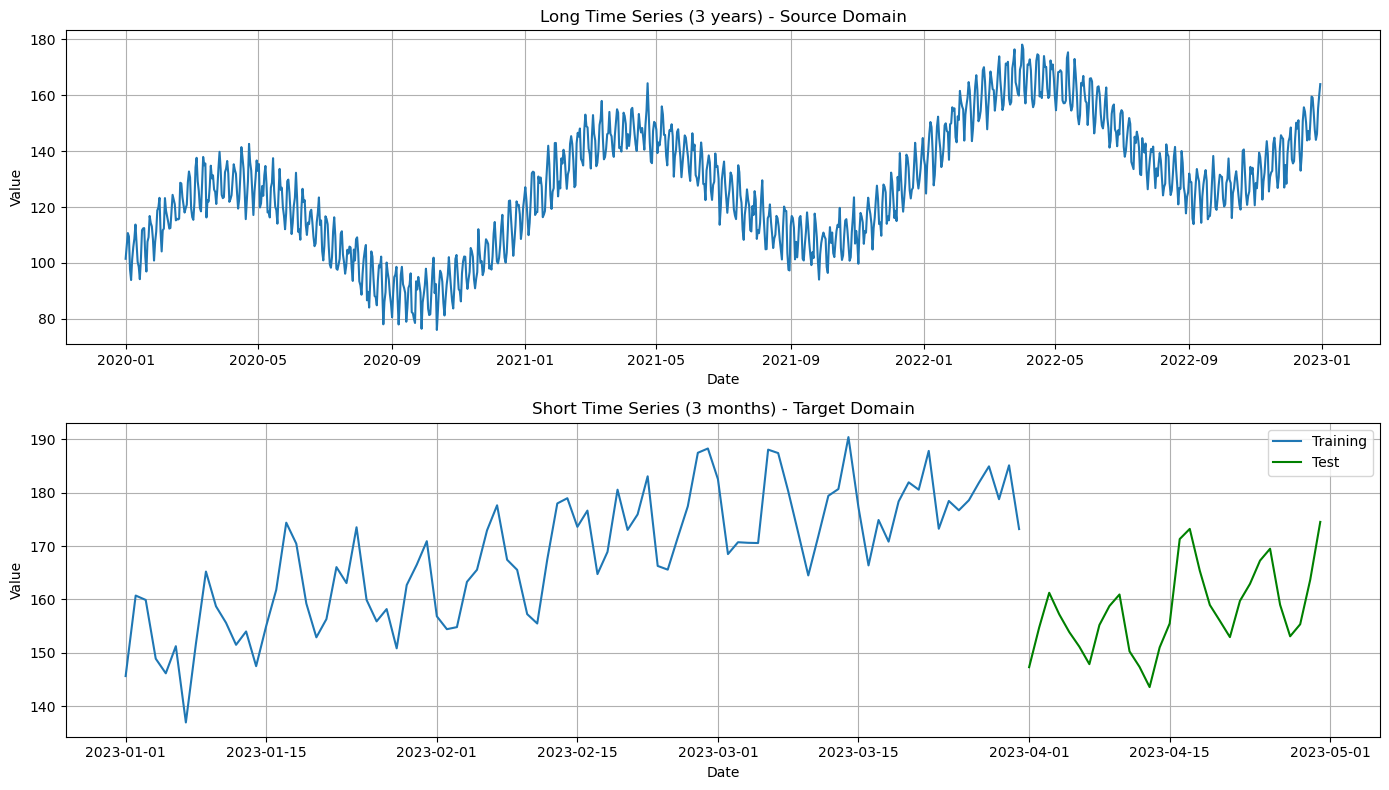

In [6]:
# Visualize both series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(long_series["ds"], long_series["y"])
axes[0].set_title("Long Time Series (3 years) - Source Domain")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Value")
axes[0].grid(True)

axes[1].plot(short_series["ds"], short_series["y"], label="Training")
axes[1].plot(short_series_test["ds"], short_series_test["y"], "g-", label="Test")
axes[1].set_title("Short Time Series (3 months) - Target Domain")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Value")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 5. Transfer Learning / Tuning Testing

### 5.1 Fit on Long Series

In [7]:
# Define model for long series
model_long = (
    LinearTrend(n_changepoints=15, pool_type="complete")
    + FourierSeasonality(
        period=365.25, series_order=10, pool_type="complete", tune_method="parametric"
    )
    + FourierSeasonality(
        period=7, series_order=3, pool_type="complete", tune_method="parametric"
    )
)

print(f"Model: {model_long}")

Model: LT(n=15,r=0.8,tm=None) + FS(p=365.25,n=10,tm=parametric) + FS(p=7,n=3,tm=parametric)


In [8]:
# Fit on long series
model_long.fit(
    long_series,
    scaler="maxabs",
    scale_mode="complete",
    method="mapx",
    progressbar=True,
)
print("Model fitted on long series!")

Model fitted on long series!


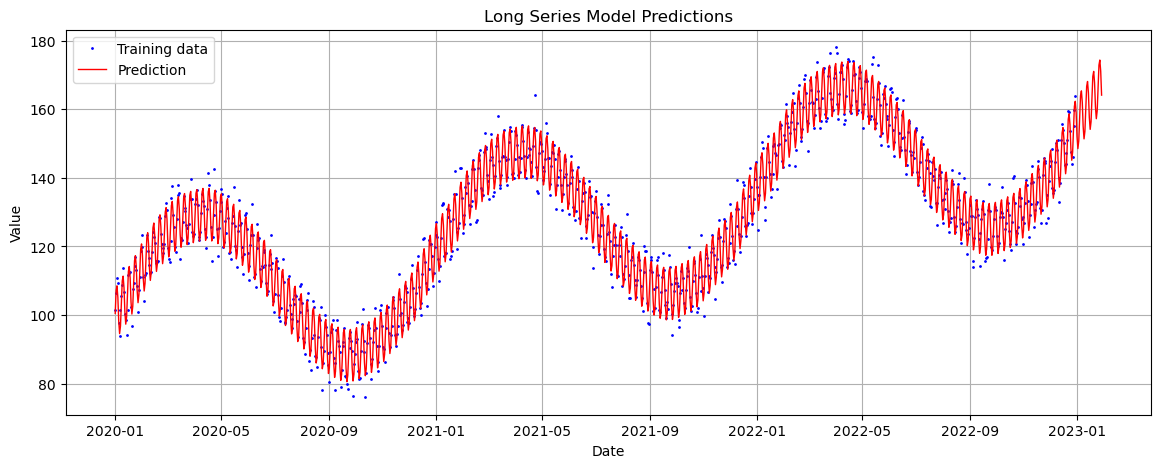

In [9]:
# Predict on long series
future_long = model_long.predict(horizon=30, freq="D")

plt.figure(figsize=(14, 5))
plt.plot(long_series["ds"], long_series["y"], "b.", label="Training data", markersize=2)
plt.plot(
    future_long["ds"], future_long["yhat_0"], "r-", label="Prediction", linewidth=1
)
plt.title("Long Series Model Predictions")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

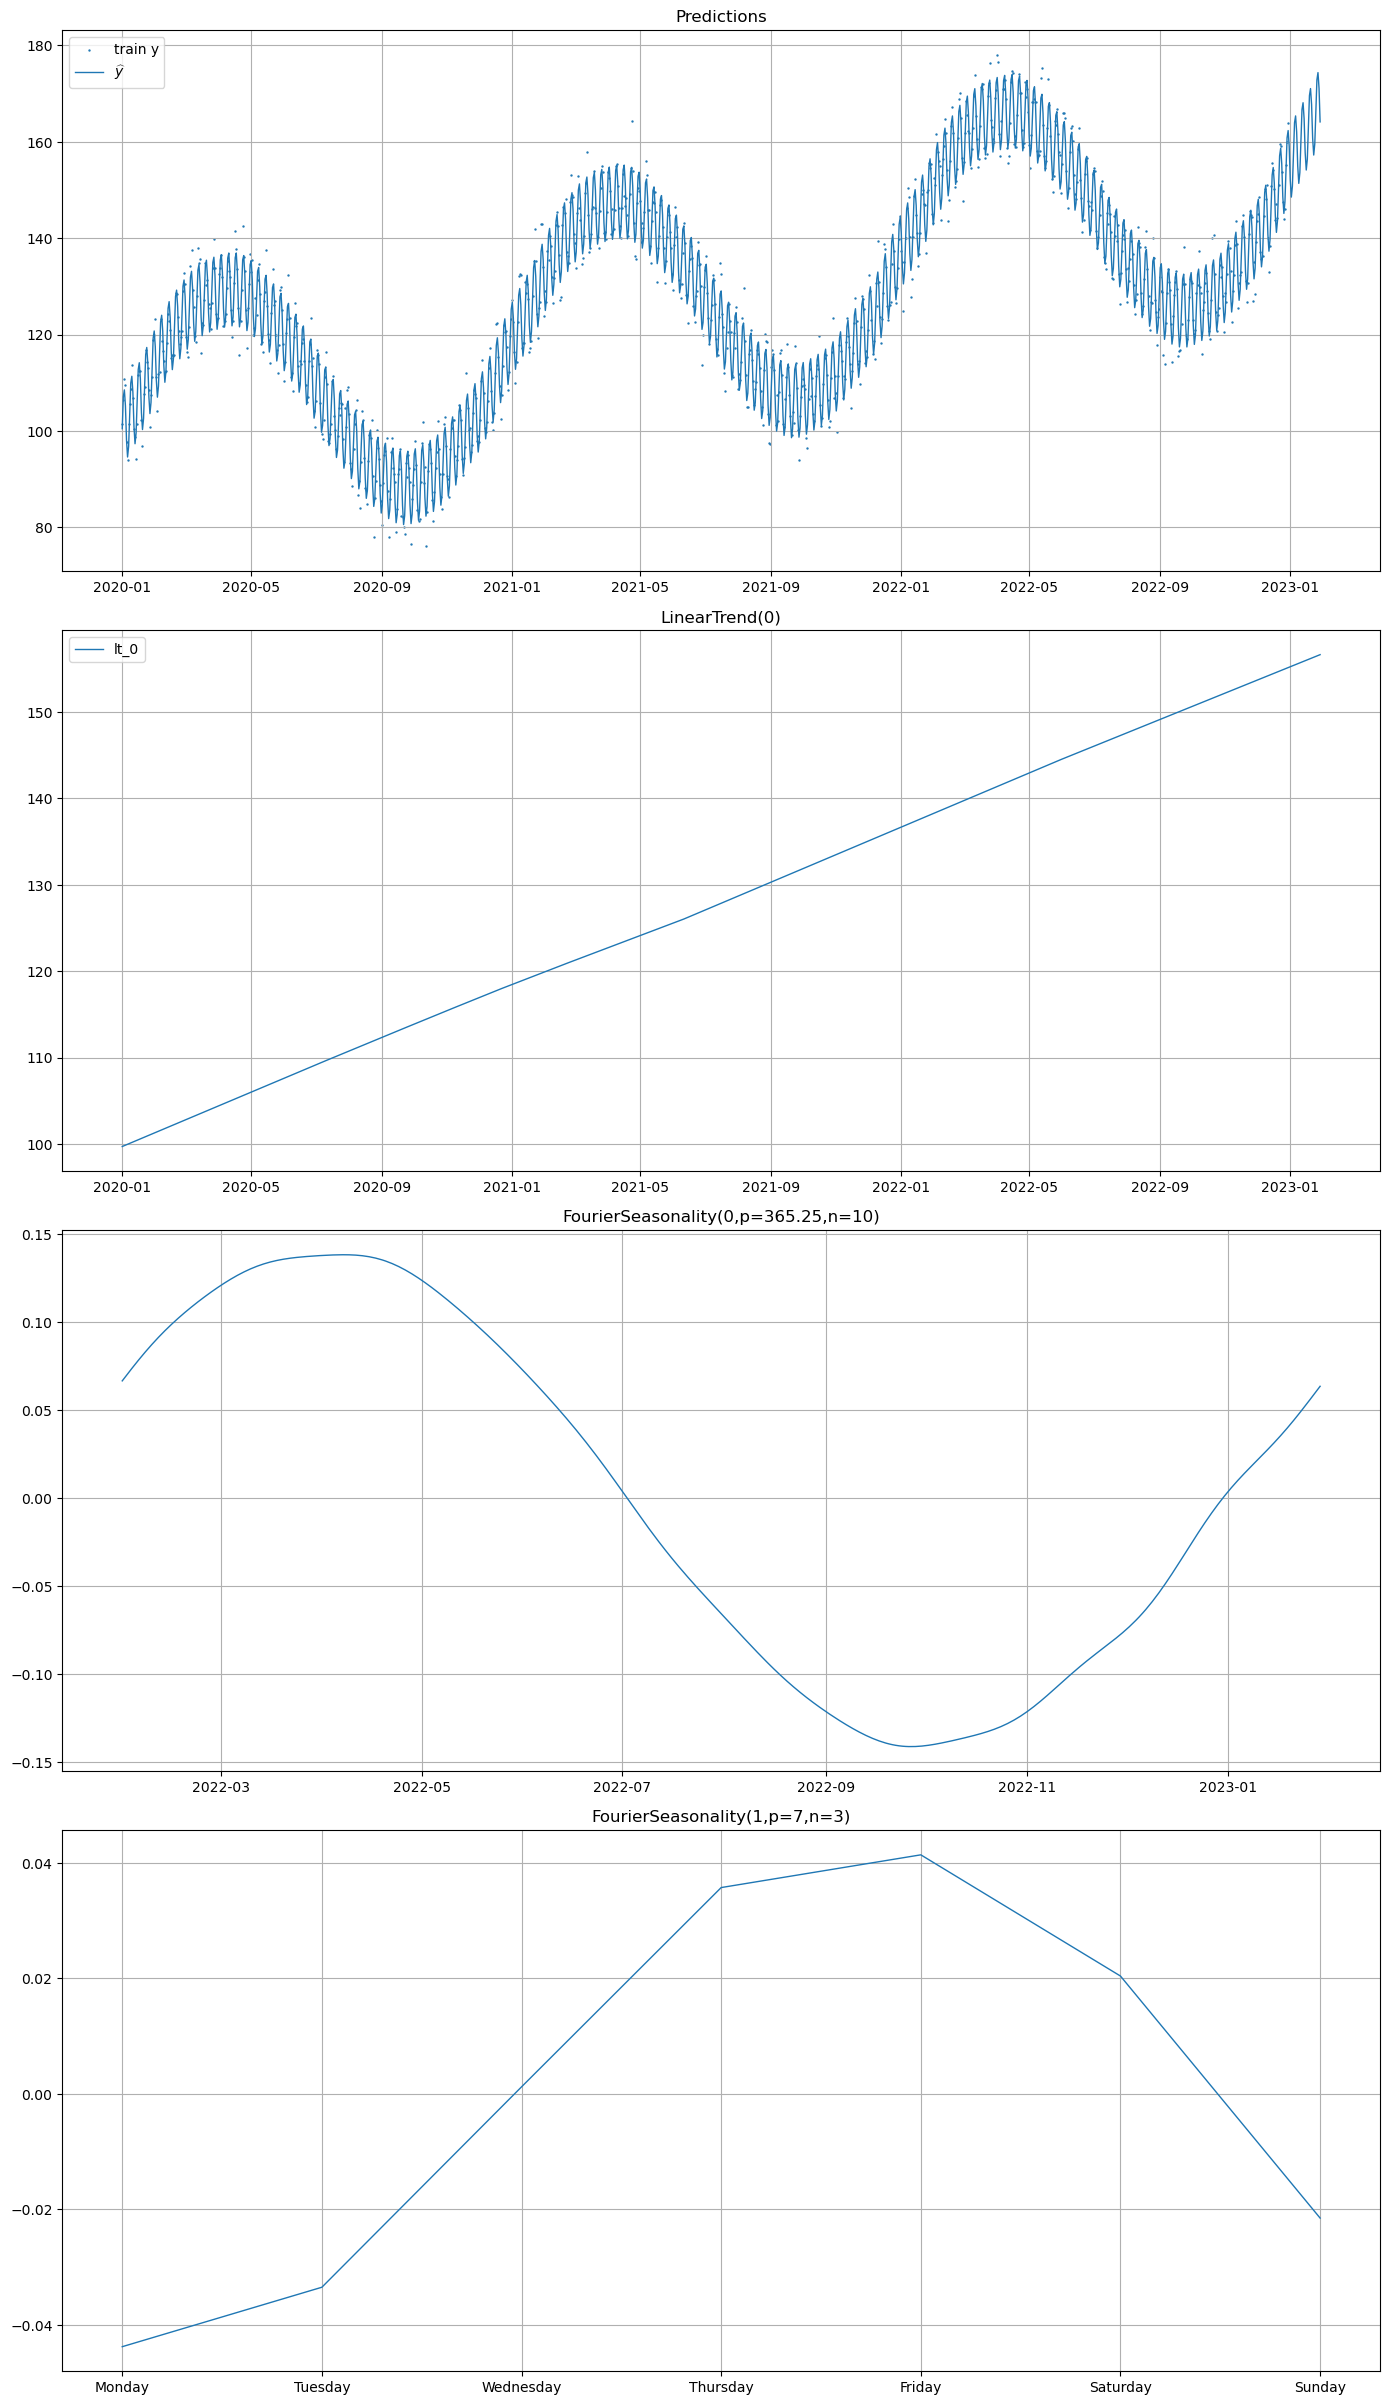

In [10]:
model_long.plot(future_long, series="long_series")
plt.tight_layout()
plt.show()

### 5.2 Baseline: Fit on Short Series Directly (without transfer learning)

In [11]:
# Fit a model directly on the short series (no transfer learning)
model_baseline = (
    LinearTrend(n_changepoints=5, pool_type="complete")
    + FourierSeasonality(period=365.25, series_order=5, pool_type="complete")
    + FourierSeasonality(period=7, series_order=3, pool_type="complete")
)

model_baseline.fit(
    short_series,
    scaler="maxabs",
    scale_mode="complete",
    method="mapx",
    progressbar=True,
)
print("Baseline model fitted on short series!")

Baseline model fitted on short series!


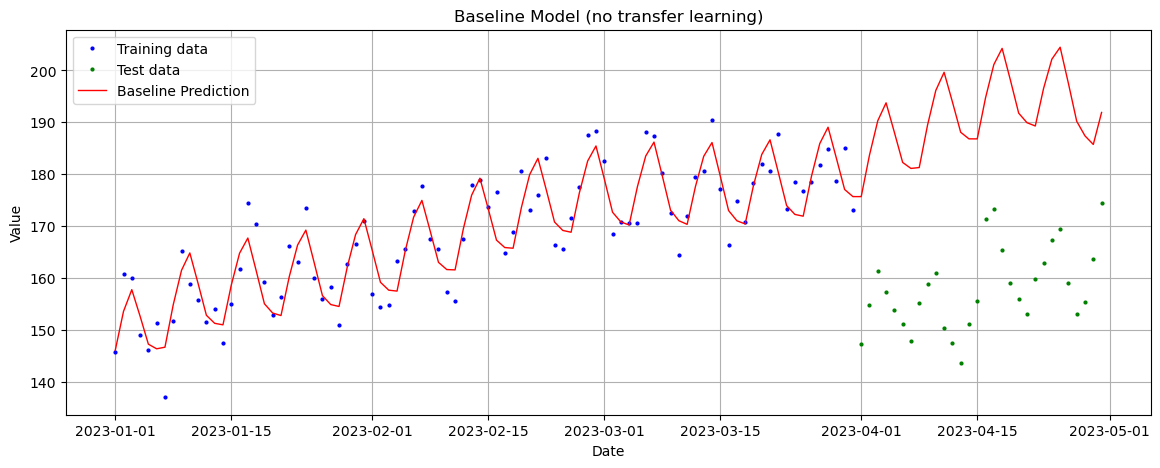

In [12]:
# Predict with baseline
future_baseline = model_baseline.predict(horizon=30, freq="D")

plt.figure(figsize=(14, 5))
plt.plot(
    short_series["ds"], short_series["y"], "b.", label="Training data", markersize=4
)
plt.plot(
    short_series_test["ds"],
    short_series_test["y"],
    "g.",
    label="Test data",
    markersize=4,
)
plt.plot(
    future_baseline["ds"],
    future_baseline["yhat_0"],
    "r-",
    label="Baseline Prediction",
    linewidth=1,
)
plt.title("Baseline Model (no transfer learning)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

### 5.3 Transfer Learning: Use idata from long series to fit short series

In [13]:
# First, we need to get the trace/idata from the long model
# For transfer learning, we need to use MCMC sampling to get the posterior
model_long_mcmc = (
    LinearTrend(n_changepoints=15, pool_type="complete")
    + FourierSeasonality(
        period=365.25, series_order=10, pool_type="complete", tune_method="parametric"
    )
    + FourierSeasonality(
        period=7, series_order=3, pool_type="complete", tune_method="parametric"
    )
)

# Fit using NUTS to get posterior samples
model_long_mcmc.fit(
    long_series,
    scaler="maxabs",
    scale_mode="complete",
    method="nuts",
    samples=500,
    chains=2,
    cores=2,
    progressbar=True,
)
print("MCMC model fitted on long series!")

TypeError: Cannot convert Type Vector(float64, shape=(1,)) (of Variable float64{[0.35072133]}) into Type Scalar(float64, shape=()). You can try to manually convert float64{[0.35072133]} into a Scalar(float64, shape=()).

In [ ]:
# Extract the idata for transfer learning
idata_long = model_long_mcmc.trace
print(f"Posterior variables: {list(idata_long['posterior'].data_vars)}")

In [ ]:
# Now fit a new model on the short series using the idata from the long series
model_transfer = (
    LinearTrend(n_changepoints=5, pool_type="complete")
    + FourierSeasonality(
        period=365.25, series_order=10, pool_type="complete", tune_method="parametric"
    )
    + FourierSeasonality(
        period=7, series_order=3, pool_type="complete", tune_method="parametric"
    )
)

# Fit with idata (transfer learning)
model_transfer.fit(
    short_series,
    scaler="maxabs",
    scale_mode="complete",
    method="mapx",
    progressbar=True,
    idata=idata_long,
)
print("Transfer learning model fitted on short series!")

In [ ]:
# Predict with transfer learning model
future_transfer = model_transfer.predict(horizon=30, freq="D")

# Compare baseline vs transfer learning
plt.figure(figsize=(14, 5))
plt.plot(
    short_series["ds"], short_series["y"], "b.", label="Training data", markersize=4
)
plt.plot(
    short_series_test["ds"],
    short_series_test["y"],
    "g.",
    label="Test data",
    markersize=4,
)
plt.plot(
    future_baseline["ds"],
    future_baseline["yhat_0"],
    "r-",
    label="Baseline",
    linewidth=1,
    alpha=0.7,
)
plt.plot(
    future_transfer["ds"],
    future_transfer["yhat_0"],
    "m-",
    label="Transfer Learning",
    linewidth=1,
    alpha=0.7,
)
plt.title("Baseline vs Transfer Learning")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_transfer.plot(
    future_transfer, series="short_series", y_true=short_series_test
)
plt.tight_layout()
plt.show()

In [ ]:
## 6. Test Constant Components

# Test NormalConstant
model_nc = LinearTrend(n_changepoints=5, pool_type="complete") + NormalConstant(
    mu=0, sd=10
)
print(f"Model with NormalConstant: {model_nc}")

try:
    model_nc.fit(
        short_series,
        scaler="maxabs",
        scale_mode="complete",
        method="mapx",
        progressbar=True,
    )
    future_nc = model_nc.predict(horizon=30, freq="D")
    print("NormalConstant model fitted successfully!")
except Exception as e:
    print(f"ERROR with NormalConstant: {type(e).__name__}: {e}")
# Test UniformConstant
model_uc = LinearTrend(n_changepoints=5, pool_type="complete") + UniformConstant(
    lower=-10, upper=10
)
print(f"Model with UniformConstant: {model_uc}")

try:
    model_uc.fit(
        short_series,
        scaler="maxabs",
        scale_mode="complete",
        method="mapx",
        progressbar=True,
    )
    future_uc = model_uc.predict(horizon=30, freq="D")
    print("UniformConstant model fitted successfully!")
except Exception as e:
    print(f"ERROR with UniformConstant: {type(e).__name__}: {e}")
# Test BetaConstant
model_bc = LinearTrend(n_changepoints=5, pool_type="complete") * BetaConstant(
    lower=0.5, upper=1.5, alpha=2, beta=2
)
print(f"Model with BetaConstant: {model_bc}")

try:
    model_bc.fit(
        short_series,
        scaler="maxabs",
        scale_mode="complete",
        method="mapx",
        progressbar=True,
    )
    future_bc = model_bc.predict(horizon=30, freq="D")
    print("BetaConstant model fitted successfully!")
except Exception as e:
    print(f"ERROR with BetaConstant: {type(e).__name__}: {e}")
## 7. Test Multi-Series Data

# Create multi-series dataset
series_a = generate_similar_time_series(
    n_days=365,
    start_date="2020-01-01",
    series_name="series_a",
    trend_slope=0.1,
    trend_intercept=100,
    yearly_amplitude=20,
    weekly_amplitude=5,
    noise_level=3,
    random_seed=42,
)

series_b = generate_similar_time_series(
    n_days=365,
    start_date="2020-01-01",
    series_name="series_b",
    trend_slope=0.15,
    trend_intercept=80,
    yearly_amplitude=15,
    weekly_amplitude=8,
    noise_level=4,
    random_seed=123,
)

multi_series = pd.concat([series_a, series_b], ignore_index=True)
print(f"Multi-series data shape: {multi_series.shape}")
print(f"Series: {multi_series['series'].unique()}")
# Test partial pooling with multi-series
model_partial = (
    LinearTrend(n_changepoints=10, pool_type="partial")
    + FourierSeasonality(period=365.25, series_order=5, pool_type="partial")
    + FourierSeasonality(period=7, series_order=3, pool_type="partial")
)

print(f"Partial pooling model: {model_partial}")

try:
    model_partial.fit(
        multi_series,
        scaler="maxabs",
        scale_mode="individual",
        method="mapx",
        progressbar=True,
    )
    future_partial = model_partial.predict(horizon=30, freq="D")
    print("Partial pooling model fitted successfully!")
except Exception as e:
    print(f"ERROR with partial pooling: {type(e).__name__}: {e}")
# Test plotting for multi-series
try:
    model_partial.plot(future_partial, series="series_a")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"ERROR in plotting series_a: {type(e).__name__}: {e}")

try:
    model_partial.plot(future_partial, series="series_b")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"ERROR in plotting series_b: {type(e).__name__}: {e}")
## 8. Calculate Metrics

# Metrics for additive model on air passengers
try:
    metrics_additive = metrics(test, future_additive, "complete")
    print("Additive Model Metrics:")
    display(metrics_additive)
except Exception as e:
    print(f"ERROR calculating metrics: {type(e).__name__}: {e}")
# Metrics for multiplicative model on air passengers
try:
    metrics_mult = metrics(test, future_mult, "complete")
    print("Multiplicative Model Metrics:")
    display(metrics_mult)
except Exception as e:
    print(f"ERROR calculating metrics: {type(e).__name__}: {e}")
